## Optimization of functions loaded in MPS

This notebook shows how to optimize a MPS, that is, find its minimum and maximum value together their corresponding indices, using the routine `optimize_mps`. The underlying optimization method is `optima_tt` (https://arxiv.org/abs/2209.14808). This method requires polynomial resources for multi-qubit states and hence avoids the curse of dimensionality.

In this example, we are going to apply this method to compute the extrema of a linear combination of harmonic functions.

$$
    f(x) = \sum_{k=1}^{N} a_k\cos(\omega_k x + \phi_k),
$$

where $a_k$, $\omega_k$ and $\phi_k$ are taken at random. For demonstration purposes, this function is loaded in MPS using the SVD decomposition. However, the scope of the method is the optimization of exponentially large functions whose tensors are computationally intractable, which can be built using other function loading algorithms such as Chebyshev approximations, tensor cross-interpolation, solutions of PDEs, etc.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from seemps.state import MPS
from seemps.analysis.mesh import RegularInterval
from seemps.analysis.optimization import optimize_mps

In [9]:
num_terms = 100
amplitudes = np.random.uniform(0.5, 2.0, num_terms)
frequencies = np.random.uniform(100.0, 200.0, num_terms)
phases = np.random.uniform(0, 2 * np.pi, num_terms)


def func(x):
    y = np.zeros_like(x)
    for a, φ, ω in zip(amplitudes, phases, frequencies):
        y += a * np.cos(ω * x + φ)
    return y

Min:  -34.68646224704873  Max:  33.87831269613038


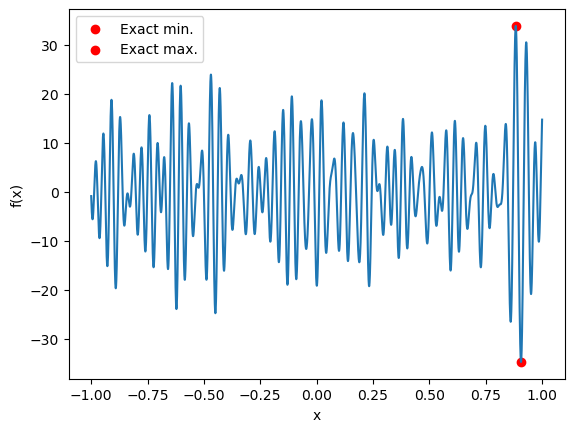

In [10]:
start = -1
stop = 1
num_qubits = 15
domain = RegularInterval(start, stop, 2**num_qubits)

x = domain.to_vector()
y_vec = func(x)

i_min_vec = np.argmin(y_vec)
y_min_vec = y_vec[i_min_vec]
i_max_vec = np.argmax(y_vec)
y_max_vec = y_vec[i_max_vec]

print("Min: ", y_min_vec, " Max: ", y_max_vec)

plt.plot(x, y_vec)
plt.scatter(x[i_min_vec], y_min_vec, color="r", label="Exact min.")
plt.scatter(x[i_max_vec], y_max_vec, color="r", label="Exact max.")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()

In [12]:
# Load the function in MPS using SVD
mps = MPS.from_vector(y_vec, [2] * num_qubits, normalize=False)
y_mps = mps.to_vector()
err = np.max(np.abs(y_mps - y_vec))
print("Maxbond: ", mps.max_bond_dimension())
print("Loading error: ", err)

Maxbond:  16
Loading error:  1.9786703573387854e-06


Min:  -34.68646231285264  Max:  33.87831276218731


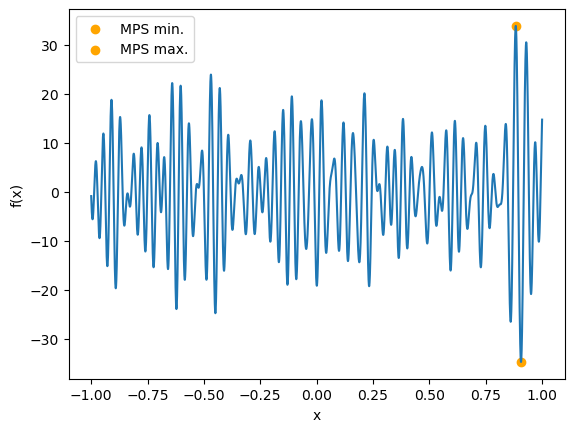

In [13]:
# Optimize the MPS using `optimze_mps`
(j_min, y_min_mps), (j_max, y_max_mps) = optimize_mps(mps)
print("Min: ", y_min_mps, " Max: ", y_max_mps)

bitlist_to_int = lambda bitlist: int("".join(str(x) for x in bitlist), 2)

i_min_mps = bitlist_to_int(j_min)
i_max_mps = bitlist_to_int(j_max)

plt.plot(x, y_vec)
plt.scatter(x[i_min_mps], y_min_mps, color="orange", label="MPS min.")
plt.scatter(x[i_max_mps], y_max_mps, color="orange", label="MPS max.")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()